# Import

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC

# Reading data

In [ ]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
df['Glucose']=df['Glucose'].replace(0,df['Glucose'].mean())#normal distribution
df['BloodPressure']=df['BloodPressure'].replace(0,df['BloodPressure'].mean())#normal distribution
df['SkinThickness']=df['SkinThickness'].replace(0,df['SkinThickness'].median())#skewed distribution
df['Insulin']=df['Insulin'].replace(0,df['Insulin'].median())#skewed distribution
df['BMI']=df['BMI'].replace(0,df['BMI'].median())#skewed distribution

<Axes: xlabel='DiabetesPedigreeFunction'>

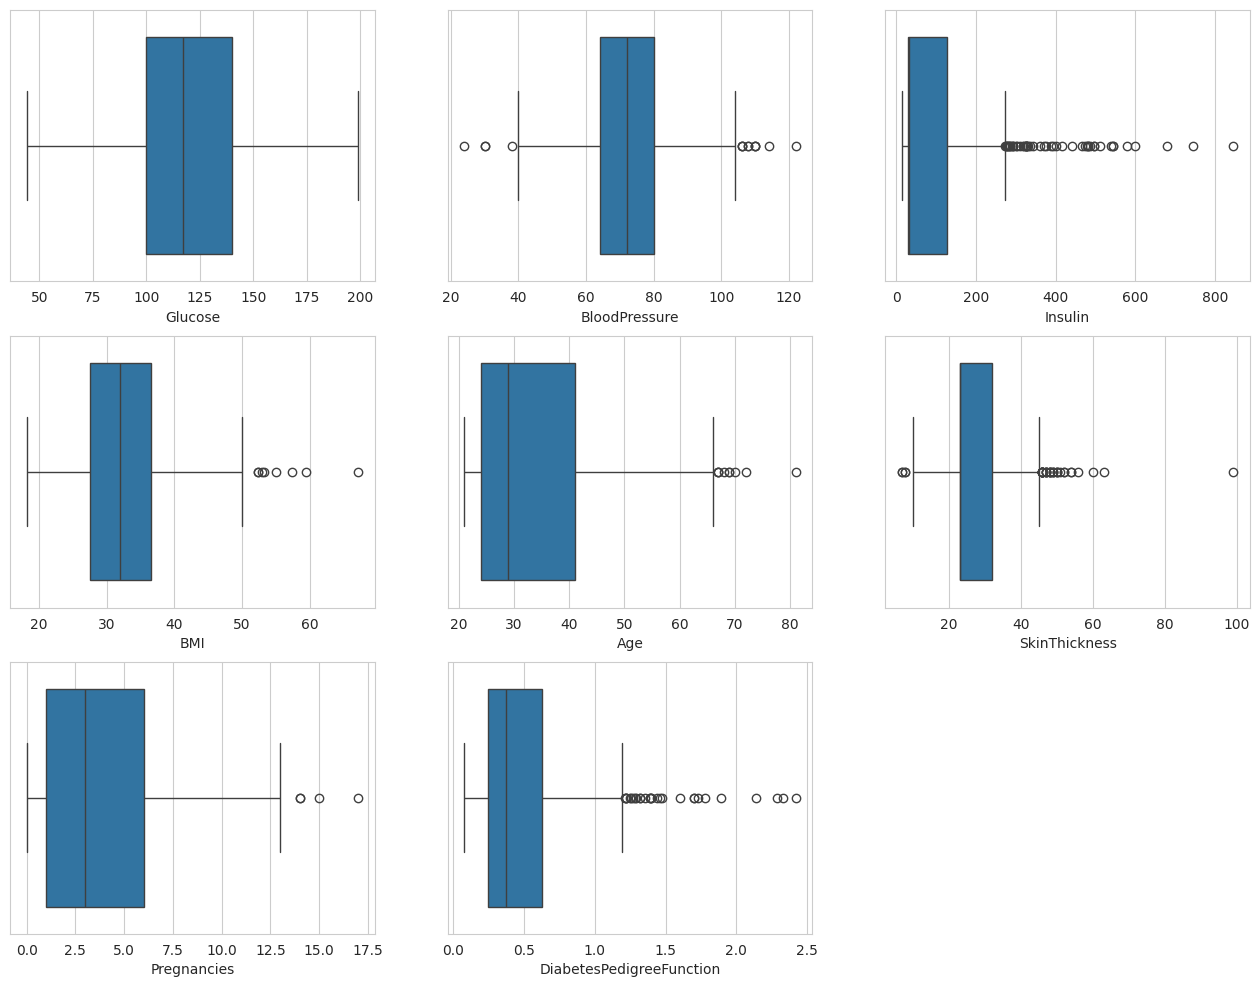

In [ ]:
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(x='Glucose',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='BloodPressure',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='Insulin',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='BMI',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='Age',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='SkinThickness',data=df)
plt.subplot(3,3,7)
sns.boxplot(x='Pregnancies',data=df)
plt.subplot(3,3,8)
sns.boxplot(x='DiabetesPedigreeFunction',data=df)

In [ ]:
for i in df.columns:
  QT = df[i].quantile(0.75) - df[i].quantile(0.25)
  df.drop(df[(df[i].values<(df[i].quantile(0.25)-1.2*QT)) | (df[i].values>(df[i].quantile(0.75)+1.2*QT))].index,inplace = True)

<Axes: xlabel='DiabetesPedigreeFunction'>

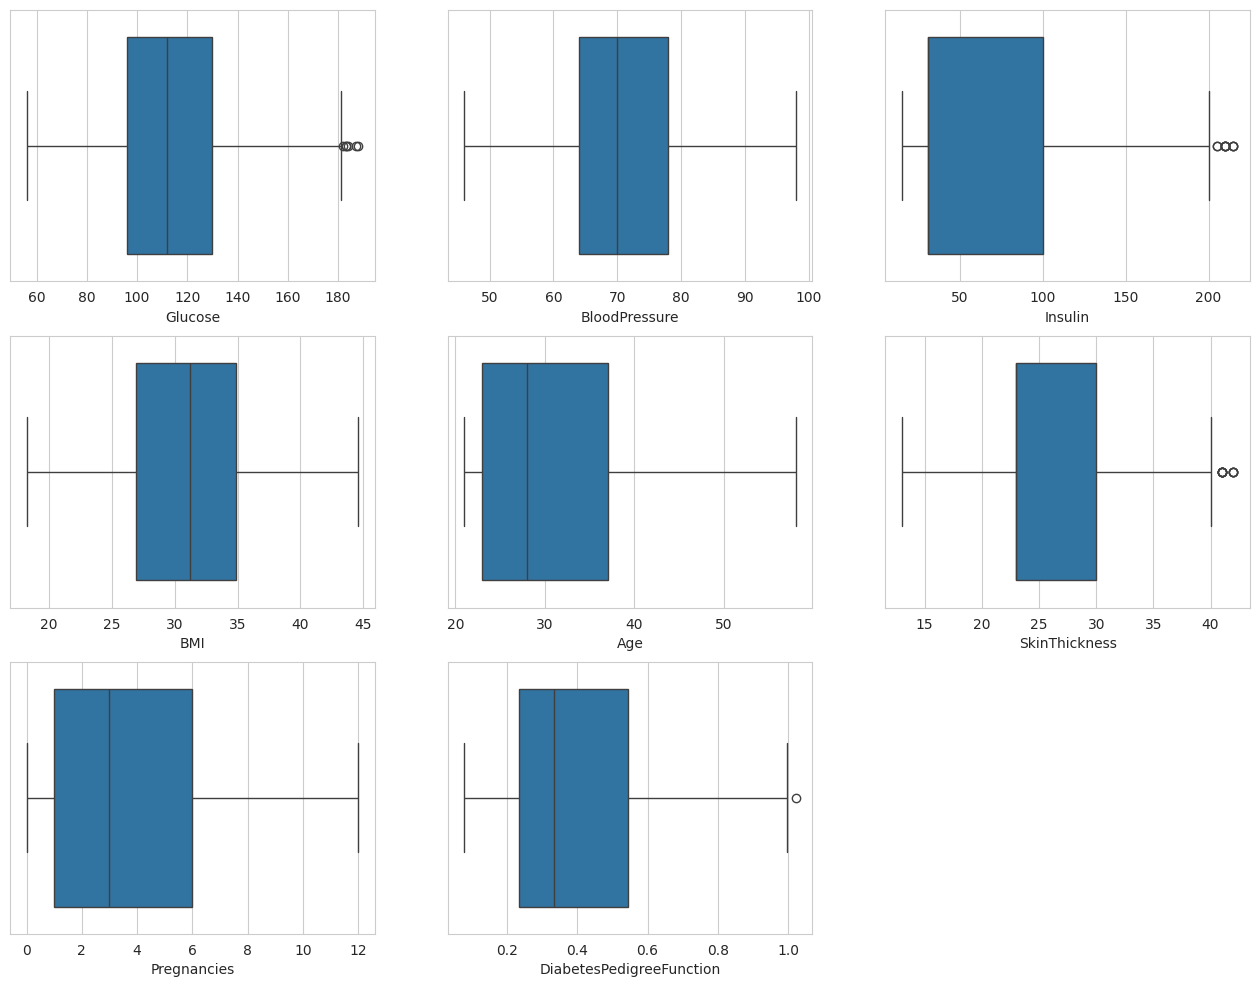

In [ ]:
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(x='Glucose',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='BloodPressure',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='Insulin',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='BMI',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='Age',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='SkinThickness',data=df)
plt.subplot(3,3,7)
sns.boxplot(x='Pregnancies',data=df)
plt.subplot(3,3,8)
sns.boxplot(x='DiabetesPedigreeFunction',data=df)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               523 non-null    int64  
 1   Glucose                   523 non-null    float64
 2   BloodPressure             523 non-null    float64
 3   SkinThickness             523 non-null    int64  
 4   Insulin                   523 non-null    float64
 5   BMI                       523 non-null    float64
 6   DiabetesPedigreeFunction  523 non-null    float64
 7   Age                       523 non-null    int64  
 8   Outcome                   523 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 36.9 KB


# ّFeature rating

In [ ]:
X = df.copy()
y = X.pop('Outcome')

In [ ]:
X.iloc[:,1:8] = X.iloc[:,1:8].astype('float')
X[['Pregnancies','Age']] = X[['Pregnancies','Age']].astype('int')
X

<ipython-input-14-ae5dc791487b>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:,1:8] = X.iloc[:,1:8].astype('float')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,30.5,33.6,0.627,50
1,1,85.0,66.0,29.0,30.5,26.6,0.351,31
2,8,183.0,64.0,23.0,30.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,5,116.0,74.0,23.0,30.5,25.6,0.201,30
...,...,...,...,...,...,...,...,...
518,9,89.0,62.0,23.0,30.5,22.5,0.142,33
519,2,122.0,70.0,27.0,30.5,36.8,0.340,27
520,5,121.0,72.0,23.0,112.0,26.2,0.245,30
521,1,126.0,60.0,23.0,30.5,30.1,0.349,47


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               523 non-null    int64  
 1   Glucose                   523 non-null    float64
 2   BloodPressure             523 non-null    float64
 3   SkinThickness             523 non-null    float64
 4   Insulin                   523 non-null    float64
 5   BMI                       523 non-null    float64
 6   DiabetesPedigreeFunction  523 non-null    float64
 7   Age                       523 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 32.8 KB


<Figure size 10000x10000 with 0 Axes>

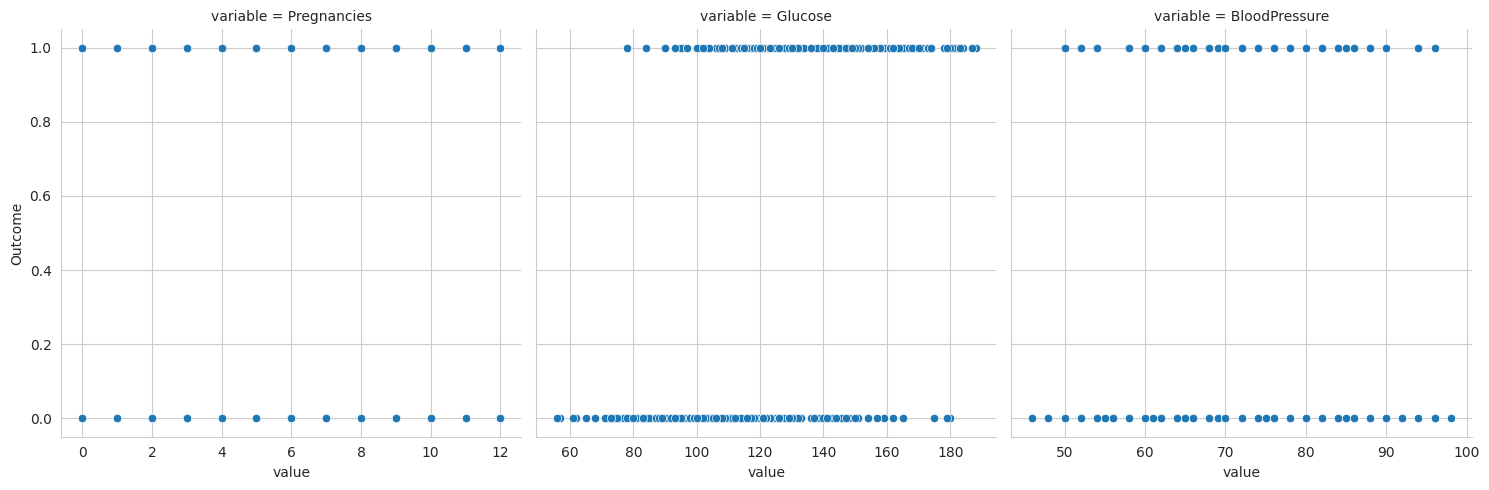

In [ ]:
plt.figure(figsize=(100,100))
features = X.columns.to_list()[0:3]
sns.relplot(
    x="value", y="Outcome", col="variable", data=df.melt(id_vars="Outcome", value_vars=features), facet_kws=dict(sharex=False),
);

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores = make_mi_scores(X, y)

In [ ]:
mi_scores

Glucose                     0.110479
Age                         0.096901
BMI                         0.054045
Insulin                     0.020420
Pregnancies                 0.013149
DiabetesPedigreeFunction    0.007472
BloodPressure               0.005165
SkinThickness               0.000000
Name: MI Scores, dtype: float64

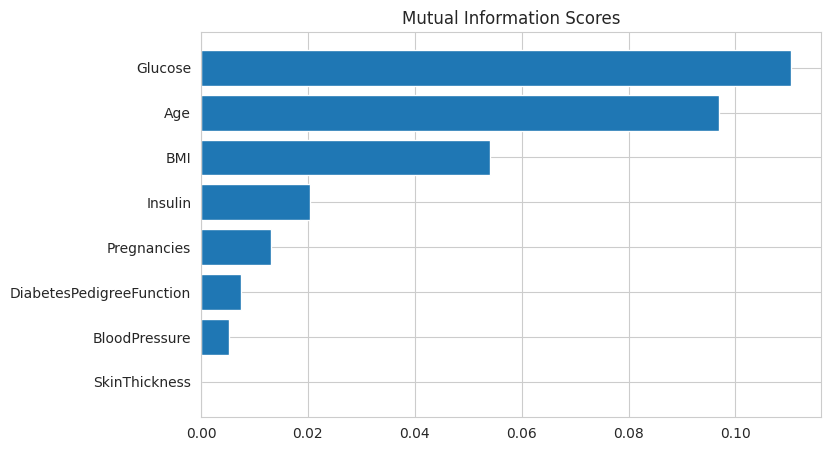

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
#df=df.drop(['BloodPressure','Insulin','Age'],axis='columns')

# Creating features

In [ ]:
def score_dataset(X, y, model=XGBRegressor()):
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
    )
    score = score.mean()
    return score

In [ ]:
print(score_dataset(X,y))

-0.18460240320421614


In [ ]:
#components = X[mi_scores.head(3).index.to_list()].columns.to_list()
#X["Components"] = X[components].gt(0).sum(axis=1)

In [ ]:
#print(score_dataset(X,y))

In [ ]:
# PCA
pca = PCA()
features = mi_scores.index.to_list()[:5]
a = X[features].copy()
X_scaled = (a - a.mean(axis=0)) / a.std(axis=0)
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,2.323645,-0.155354,-0.095555,-0.887347,0.749618
1,-1.112321,-1.170797,-0.005535,0.135390,0.748978
2,1.553573,-0.208793,1.890285,-1.911290,-1.122189
3,-1.699112,-0.011488,0.220506,0.693137,-0.030384
4,0.006439,-0.998581,0.611106,-0.383733,-0.340980


PC1    0.107137
PC4    0.086661
PC5    0.042297
PC2    0.039404
PC3    0.000000
Name: MI Scores, dtype: float64


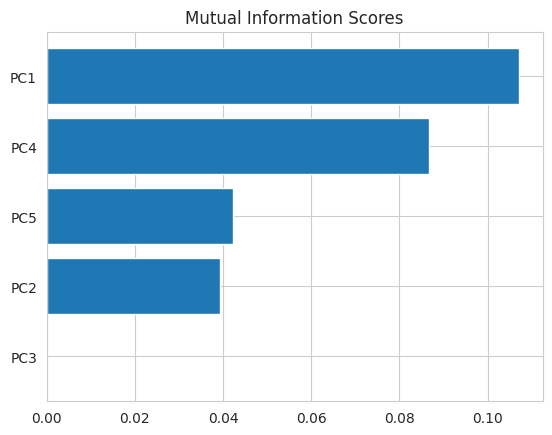

In [ ]:
pca_mi = make_mi_scores(X_pca,y)
print(pca_mi)
plot_mi_scores(pca_mi)

In [ ]:
PCX1 = X.join(X_pca[['PC1']])
score_dataset(PCX1,y)
PCX1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,PC1
0,6,148.0,72.0,35.0,30.5,33.6,0.627,50,2.323645
1,1,85.0,66.0,29.0,30.5,26.6,0.351,31,-1.112321
2,8,183.0,64.0,23.0,30.5,23.3,0.672,32,1.553573
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,-1.699112
4,5,116.0,74.0,23.0,30.5,25.6,0.201,30,0.006439
...,...,...,...,...,...,...,...,...,...
518,9,89.0,62.0,23.0,30.5,22.5,0.142,33,0.573457
519,2,122.0,70.0,27.0,30.5,36.8,0.340,27,-0.336553
520,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0.105407
521,1,126.0,60.0,23.0,30.5,30.1,0.349,47,0.673405


In [ ]:
print(X_pca.shape)
X.shape

(523, 5)


(523, 8)

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=a.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5
Glucose,0.344727,0.501835,0.344405,-0.705729,-0.112506
Age,0.665470,-0.154135,0.036430,0.118498,0.719739
BMI,0.205032,0.459840,-0.862456,0.014184,-0.049777
Insulin,0.007781,0.663419,0.365787,0.652637,0.008915
Pregnancies,0.629456,-0.269865,0.049274,0.248533,-0.683200


In [ ]:
#F1 = ( X_scaled['BMI'] * X_scaled['SkinThickness']  ) * ( X_scaled['Pregnancies'] * X_scaled['Age']  )
#F1 = X_scaled.Glucose * X_scaled.Pregnancies * X_scaled.Age * X_scaled.BMI * X_scaled.SkinThickness
#F1 = X.Insulin * X.BloodPressure
#PCX2 = X.copy()
#PCX1['A@G'] = F1
#make_mi_scores(PCX1,y)

In [ ]:
X = PCX1

In [ ]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,PC1
0,6,148.0,72.0,35.0,30.5,33.6,0.627,50,2.323645
1,1,85.0,66.0,29.0,30.5,26.6,0.351,31,-1.112321
2,8,183.0,64.0,23.0,30.5,23.3,0.672,32,1.553573
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,-1.699112
4,5,116.0,74.0,23.0,30.5,25.6,0.201,30,0.006439
...,...,...,...,...,...,...,...,...,...
518,9,89.0,62.0,23.0,30.5,22.5,0.142,33,0.573457
519,2,122.0,70.0,27.0,30.5,36.8,0.340,27,-0.336553
520,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0.105407
521,1,126.0,60.0,23.0,30.5,30.1,0.349,47,0.673405


In [ ]:
X['old']=X['Age'].gt(55).astype('int')
X['old'].value_counts()

0    516
1      7
Name: old, dtype: int64

In [ ]:
#a = [0,0.3,0.6,1]
#b = [0,1,2]
#X['High_P']=pd.cut(X['DiabetesPedigreeFunction'],bins=a,labels=b)
#X.fillna(0,inplace=True)
#X['High_P']=X['High_P'].astype(int)

In [ ]:
score_dataset(X, y)

-0.1814476912705742

# Model

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)

# Evaluate the performance of the model
accuracy = metrics.accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7238095238095238


Classification Report is:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        71
           1       0.59      0.47      0.52        34

    accuracy                           0.72       105
   macro avg       0.68      0.66      0.66       105
weighted avg       0.71      0.72      0.71       105


 F1:
 0.5245901639344261

 Precision score is:
 0.5925925925925926

 Recall score is:
 0.47058823529411764

 Confusion Matrix:



<Axes: >

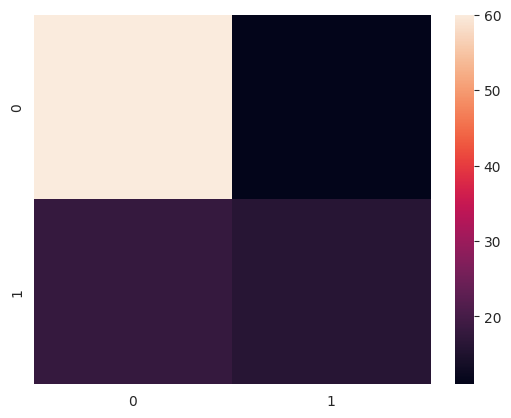

In [ ]:
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("\n F1:\n",f1_score(y_test,y_pred))
print("\n Precision score is:\n",precision_score(y_test,y_pred))
print("\n Recall score is:\n",recall_score(y_test,y_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test,y_pred))

In [ ]:
X['Pregnancies'].value_counts()

1     86
2     82
0     75
3     55
4     46
5     38
6     37
7     31
8     24
10    19
9     19
11     6
12     5
Name: Pregnancies, dtype: int64

In [ ]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

In [ ]:
svm = SVC(gamma='auto').fit(X_train,y_train)

In [ ]:
y_pred = svm.predict(X_train)
accuracy = metrics.accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8373205741626795


In [ ]:
y_pred = svm.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8380952380952381


Classification Report is:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87        71
           1       0.79      0.56      0.66        34

    accuracy                           0.81       105
   macro avg       0.80      0.74      0.76       105
weighted avg       0.81      0.81      0.80       105


 F1:
 0.6551724137931034

 Precision score is:
 0.7916666666666666

 Recall score is:
 0.5588235294117647

 Confusion Matrix:



<Axes: >

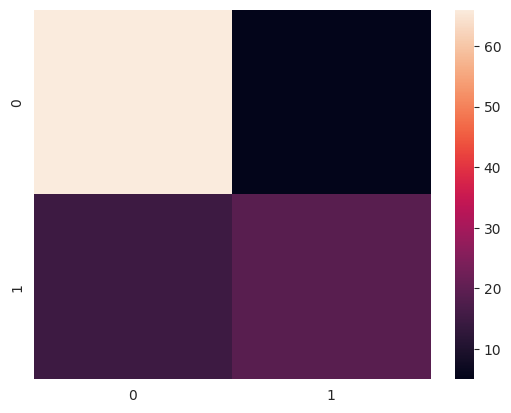

In [ ]:
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("\n F1:\n",f1_score(y_test,y_pred))
print("\n Precision score is:\n",precision_score(y_test,y_pred))
print("\n Recall score is:\n",recall_score(y_test,y_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test,y_pred))

In [ ]:
XG = XGBClassifier(learning_rate = 1.6,n_estimators=900,max_depth=8, random_state=42).fit(X_train,y_train)
#1.6

In [ ]:
y_pred = XG.predict(X_train)
accuracy = metrics.accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
y_pred = XG.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8


Classification Report is:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        71
           1       0.74      0.59      0.66        34

    accuracy                           0.80       105
   macro avg       0.78      0.74      0.76       105
weighted avg       0.79      0.80      0.79       105


 F1:
 0.6557377049180328

 Precision score is:
 0.7407407407407407

 Recall score is:
 0.5882352941176471

 Confusion Matrix:



<Axes: >

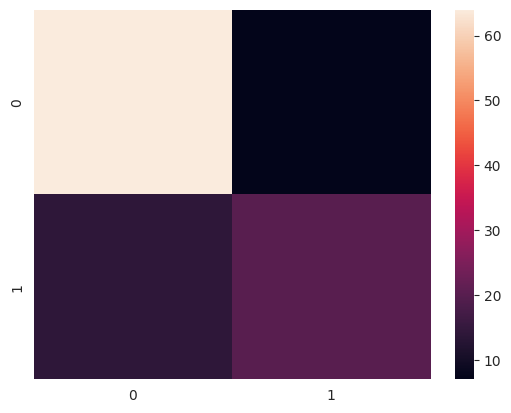

In [ ]:
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("\n F1:\n",f1_score(y_test,y_pred))
print("\n Precision score is:\n",precision_score(y_test,y_pred))
print("\n Recall score is:\n",recall_score(y_test,y_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test,y_pred))